<a href="https://colab.research.google.com/github/juwetta/DLI_Group-B/blob/main/TP072701_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1) Mount & setup**

In [1]:
# 1) Mount & setup
from google.colab import drive
drive.mount('/content/drive')

!pip -q install tabulate seaborn

import os, time, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report, f1_score, precision_score, recall_score,
    accuracy_score, roc_auc_score, confusion_matrix
)


Mounted at /content/drive


#**2) Load & split (stratified)**

In [2]:
# 2) Load & split (stratified)
DATA = "/content/drive/MyDrive/URL_dataset_clean_balanced.csv"
assert os.path.exists(DATA), f"CSV not found: {DATA}"

df = pd.read_csv(DATA)
assert {"url","type"} <= set(df.columns), f"Columns missing. Found: {df.columns.tolist()}"

X_text = df["url"].astype(str)
y      = df["type"].astype(str)   # "phishing" / "legitimate"

# Train/Val/Test = 64/16/20 split (stratified)
X_tr, X_te, y_tr, y_te = train_test_split(X_text, y, test_size=0.20, stratify=y, random_state=42)
X_tr, X_va, y_tr, y_va = train_test_split(X_tr,   y_tr, test_size=0.20, stratify=y_tr, random_state=42)

print("Sizes -> train:", len(X_tr), "val:", len(X_va), "test:", len(X_te))
y_tr.value_counts()


Sizes -> train: 133680 val: 33420 test: 41776


,count
type,
phishing,66840
legitimate,66840


#**3) Vectorizer (char TF-IDF)**

In [3]:
# 3) Vectorizer (char TF-IDF) — fast & strong for URLs
# If you have plenty of RAM, you can raise max_features to 80_000 or 100_000 for a tiny gain.
tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,5),
    min_df=5,
    max_features=50_000,    # <- adjust upward if you want
    dtype=np.float32,
    lowercase=True
)

t0 = time.time()
X_tr_m = tfidf.fit_transform(X_tr)
X_va_m = tfidf.transform(X_va)
X_te_m = tfidf.transform(X_te)
t1 = time.time()

print(f"TF-IDF in {(t1 - t0):.1f}s  |  shapes -> train {X_tr_m.shape}, val {X_va_m.shape}, test {X_te_m.shape}")


TF-IDF in 40.2s  |  shapes -> train (133680, 50000), val (33420, 50000), test (41776, 50000)


#**4) Train LinearSVC**

In [4]:
# 4) Train LinearSVC (fast)
# dual=False is typically faster when n_samples > n_features (true here with 50k features and big sample count)
svm = LinearSVC(C=1.0, class_weight="balanced", dual=False, random_state=42)

t0 = time.time()
svm.fit(X_tr_m, y_tr)
t1 = time.time()

print(f"SVM trained in {(t1 - t0):.1f}s")
print("Classes:", svm.classes_)


SVM trained in 5.0s
Classes: ['legitimate' 'phishing']


#**5) Threshold tuning on validation**

In [5]:
# 5) Threshold tuning on validation (maximize F1 for "phishing")
# LinearSVC has no predict_proba, so we use decision_function scores.
# Ensure positive scores mean "phishing":
def scores_for_class(model, X, positive_label="phishing"):
    s = model.decision_function(X)
    # For LinearSVC, positive scores map to classes_[1]. Flip if needed so that higher = phishing
    if model.classes_[1] != positive_label:
        s = -s
    return s

va_scores = scores_for_class(svm, X_va_m, positive_label="phishing")

# Pick thresholds via score percentiles (robust & fast)
percentiles = np.linspace(5, 95, 91)
cand_thr = np.percentile(va_scores, percentiles)

best_f1, best_t = 0.0, 0.0
for t in cand_thr:
    pred = np.where(va_scores >= t, "phishing", "legitimate")
    f1 = f1_score(y_va, pred, pos_label="phishing")
    if f1 > best_f1:
        best_f1, best_t = f1, float(t)

print(f"Best val F1={best_f1:.4f} at threshold={best_t:.6f}")


Best val F1=0.9976 at threshold=-0.369892


#**6) Test evaluation + summary table + confusion matrix**


== LinearSVC @thr=0.0 (default) ==
              precision    recall  f1-score   support

  legitimate      0.996     0.999     0.998     20888
    phishing      0.999     0.996     0.998     20888

    accuracy                          0.998     41776
   macro avg      0.998     0.998     0.998     41776
weighted avg      0.998     0.998     0.998     41776


== LinearSVC @best threshold ==
              precision    recall  f1-score   support

  legitimate      0.998     0.998     0.998     20888
    phishing      0.998     0.998     0.998     20888

    accuracy                          0.998     41776
   macro avg      0.998     0.998     0.998     41776
weighted avg      0.998     0.998     0.998     41776


+-------------------------+------------+-------------+----------+------------+-----------+-----------------------------------+------------------------+-----------+
| Model                   |   Accuracy |   Precision |   Recall |   F1 Score |   ROC-AUC | Params               

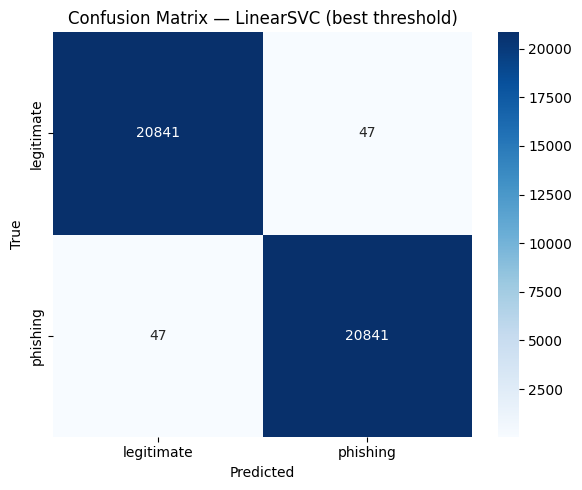

Saved classification_report_linear_svc.csv & confusion_matrix_linear_svc.png


In [6]:
# 6) Test evaluation + summary table + confusion matrix
te_scores = scores_for_class(svm, X_te_m, positive_label="phishing")

# Default SVM decision boundary (0.0)
y_pred_default = np.where(te_scores >= 0.0, "phishing", "legitimate")
# Best threshold from validation
y_pred_best    = np.where(te_scores >= best_t, "phishing", "legitimate")

def report_one(y_true, y_pred, title):
    acc  = accuracy_score(y_true, y_pred) * 100
    prec = precision_score(y_true, y_pred, pos_label="phishing", zero_division=0) * 100
    rec  = recall_score(y_true, y_pred, pos_label="phishing", zero_division=0) * 100
    f1   = f1_score(y_true, y_pred, pos_label="phishing", zero_division=0) * 100
    print(f"\n== {title} ==")
    print(classification_report(y_true, y_pred, digits=3))
    return acc, prec, rec, f1

acc0, p0, r0, f10 = report_one(y_te, y_pred_default, "LinearSVC @thr=0.0 (default)")
accB, pB, rB, f1B = report_one(y_te, y_pred_best,    "LinearSVC @best threshold")

# ROC-AUC (with scores aligned so higher=phishing)
y_te_int = (y_te == "phishing").astype(int)
auc = roc_auc_score(y_te_int, te_scores) * 100

# Inference timing (ms/sample)
t0 = time.time()
_ = svm.decision_function(X_te_m[:2000])   # sample a chunk for stable timing
t1 = time.time()
infer_ms = (t1 - t0) / 2000 * 1000

# ASCII Summary
summary = pd.DataFrame([{
    "Model": "LinearSVC (char TF-IDF)",
    "Accuracy": f"{accB:.3f}",
    "Precision": f"{pB:.3f}",
    "Recall": f"{rB:.3f}",
    "F1 Score": f"{f1B:.3f}",
    "ROC-AUC": f"{auc:.3f}",
    "Params": f"ngrams=3-5, max_feat={tfidf.max_features}, C={svm.C}",
    "Inference(ms/sample)": f"{infer_ms:.4f}",
    "BestThr": f"{best_t:.6f}",
}])
print("\n" + tabulate(summary, headers="keys", tablefmt="grid", showindex=False))

# Confusion Matrix (best threshold)
cm = confusion_matrix(y_te, y_pred_best, labels=["legitimate","phishing"])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["legitimate","phishing"],
            yticklabels=["legitimate","phishing"])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix — LinearSVC (best threshold)")
plt.tight_layout()
plt.savefig("confusion_matrix_linear_svc.png", dpi=150)
plt.show()

# Save the table as CSV
summary.to_csv("classification_report_linear_svc.csv", index=False)
print("Saved classification_report_linear_svc.csv & confusion_matrix_linear_svc.png")
